# Example Fe55 notebook

Initially written for the bootcamp at SLAC Nov 2018 by Simon Krughoff

### Setup

Before running this notebook, you'll need to set up the `obs_lsst` package. Before doing the setup procedure below, you might want to run the notebook until it crashes so you see what the error message looks like.

Step-by-step instructions:

1. Start a terminal in JupyterLab. In the terminal, setup the Stack with the command `source /opt/lsst/software/stack/loadLSST.bash` and then issue the command `setup lsst_distrib` to allow you to run scons in a subsequent step.

2. Create and/or switch into a folder where you want to put your local versions of the LSST Stack (e.g., `~/repos`)

Run the following commands

```
git clone https://github.com/lsst/obs_lsstCam.git
cd obs_lsstCam
setup -j -r .
scons
```

3. Add `setup -k -r path_to_repos/obs_lsstCam` to `$HOME/notebooks/.user_setups`.

4. Restart your kernel.

Just for fun, check what version of the Stack you are using. This notebook has been tested on `w_2018_45`.

In [1]:
! eups list -s | grep lsst_distrib

lsst_distrib          16.0-1-g3bbe181+32 	current d_2018_11_13 setup


### Imports

In [1]:
%matplotlib inline

# system imports
from matplotlib import pylab as plt
from scipy.optimize import leastsq
import numpy
import os

# LSST stack imports
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay
from lsst.ip.isr import IsrTask
import lsst.afw.detection as afwDetection


# Firefly client imports
from firefly_client import FireflyClient
from IPython.display import IFrame

### Set up the config for the ISR task.  This essentially turns off all processing other than overscan and bias correction.

In [2]:
isr_config = IsrTask.ConfigClass()

isr_config.doDark=False
isr_config.doFlat=False
isr_config.doFringe=False
isr_config.doDefect=False
isr_config.doAddDistortionModel=False
isr_config.doLinearize=False

### Construct the `IsrTask` with the above configuration

In [3]:
isr = IsrTask(config=isr_config)

### Set up the functions doing the fit

In [4]:
def double_gaussian(x, params):
    (c1, mu1, sigma1, c2, mu2, sigma2) = params
    res =  c1 * numpy.exp(-(x - mu1)**2.0/(2.0 * sigma1**2.0)) \
          + c2 * numpy.exp(-(x - mu2)**2.0/(2.0 * sigma2**2.0))
    return res

def double_gaussian_fit(params, x, y):
    fit = double_gaussian( x, params )
    return (fit - y)

### Loop over amps and fit a double gaussian to the distribution of counts in detections

In [5]:
xs = []
ys = []
fits = []
detector_names = []
detector_snames = []


def fit_foots():
    
    amp_names = []
    counts = {}

    first = True
    for vs in visits :
        
        for detector_num in range(9):

            dId = {'visit': vs, 'detector': detector_num}
            raw = butler.get('raw', **dId)
            bias = butler.get('bias', **dId)

#        print("raw files = ",raw)
    
            result = isr.run(raw, bias=bias)
#        print("result = ",result)

            detector = result.exposure.getDetector()
            detector_snames.append(detector.getName())
    
            i_amp = 0
            for amp in detector:
                if first :
                        detector_names.append(detector_num)
                masked_img = result.exposure.getMaskedImage()
                work_img = masked_img[amp.getBBox()]
                arr = work_img.getImage().getArray()
    
                bkgd = numpy.median(arr) # estimate a background and subtract it
#            print("amp = ",amp.getName(),"bkgd = %11.3e" % bkgd)
                arr -= bkgd

                thresh = afwDetection.Threshold(100)
                fs = afwDetection.FootprintSet(work_img, thresh) # detect hits
                fs = afwDetection.FootprintSet(fs, 1, False) # grow the detection footprints
                fs.makeHeavy(work_img)

                foots = fs.getFootprints()

                uniq_amp_name = detector.getName()+"_"+amp.getName()
                print("processing uniq_amp_name = ",uniq_amp_name)
                if first :
                    counts[uniq_amp_name] = []
                    amp_names.append(uniq_amp_name)

                for foot in foots:
#        print ("foot print dump:")
#        print (foot.getImageArray())
                    if foot.getImageArray().size < 25:  # throw out big footprints/CRs since we know the hits should be in a single pixel modulo the charge diffusion.
                        counts[uniq_amp_name].append(numpy.sum(foot.getImageArray()))
        first = False
        
#    print("amp_names = ",amp_names)
    print("*** doing fits ***")
    for amp_name in amp_names:
        print("running fit for ",amp_name)
        hist = numpy.histogram(counts[amp_name], bins=2100.+numpy.array(range(80))*10.) # generate distribution to fit

        y = hist[0]
        x = [(hist[1][i]+hist[1][i+1])/2 for i in range(len(hist[1])-1)]

        first_peak_guess = numpy.sum(x*y)/numpy.sum(y)
        second_peak_guess = first_peak_guess+200.0
        hit_sum = sum(counts[amp_name])
        print('amp_name = ',amp_name,' number of hits = ',hit_sum)
        Kalpha_amp_guess = hit_sum / 100000
        Kbeta_amp_guess = Kalpha_amp_guess / 5
        fit = leastsq(double_gaussian_fit, [Kalpha_amp_guess,first_peak_guess,50.,Kbeta_amp_guess,second_peak_guess,40.], args=(x, y)) # starting parameters were determined by examining a representative distribution
        
#        fit = leastsq(double_gaussian_fit, [50.,2270.,50.,10.,2550.,40.], args=(x, y)) # starting parameters were determined by examining a representative distribution
#        print("fit ")
        xs.append(x)
        ys.append(y)
#        print(ys)
        fits.append(fit)

### Retrieve the data necessary to perform ISR.  This is just the raw data and the bias frame.  Note there are multiple integrations.  This notebook only looks at one of them.

In [6]:
BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-007/'
butler = Butler(BOOTCAMP_REPO_DIR)

visits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FE55', 'testType': 'FE55'})
print(visits)



[258334666, 258334978, 258335291, 258335602, 258335913]


In [7]:
fit_foots()

processing uniq_amp_name =  R00_S00_C10
processing uniq_amp_name =  R00_S00_C11
processing uniq_amp_name =  R00_S00_C12
processing uniq_amp_name =  R00_S00_C13
processing uniq_amp_name =  R00_S00_C14
processing uniq_amp_name =  R00_S00_C15
processing uniq_amp_name =  R00_S00_C16
processing uniq_amp_name =  R00_S00_C17
processing uniq_amp_name =  R00_S00_C07
processing uniq_amp_name =  R00_S00_C06
processing uniq_amp_name =  R00_S00_C05
processing uniq_amp_name =  R00_S00_C04
processing uniq_amp_name =  R00_S00_C03
processing uniq_amp_name =  R00_S00_C02
processing uniq_amp_name =  R00_S00_C01
processing uniq_amp_name =  R00_S00_C00
processing uniq_amp_name =  R00_S01_C10
processing uniq_amp_name =  R00_S01_C11
processing uniq_amp_name =  R00_S01_C12
processing uniq_amp_name =  R00_S01_C13
processing uniq_amp_name =  R00_S01_C14
processing uniq_amp_name =  R00_S01_C15
processing uniq_amp_name =  R00_S01_C16
processing uniq_amp_name =  R00_S01_C17
processing uniq_amp_name =  R00_S01_C07


### Set up the necessary classes for using firefly to look at the data.

In [8]:
my_channel = '{}_test_channel'.format(os.environ['USER'])
server = 'https://lsst-lspdev.ncsa.illinois.edu'


#ff='{}/firefly/slate.html?__wsch={}'.format(server, my_channel)
#IFrame(ff,800,600)

In [9]:
#afwDisplay.setDefaultBackend('firefly')
#afw_display = afwDisplay.getDisplay(frame=1, 
#                                    name=my_channel)

### Display the frame after ISR

In [10]:
#afw_display.mtv(result.exposure)

### plot distributions for all 16 amps.

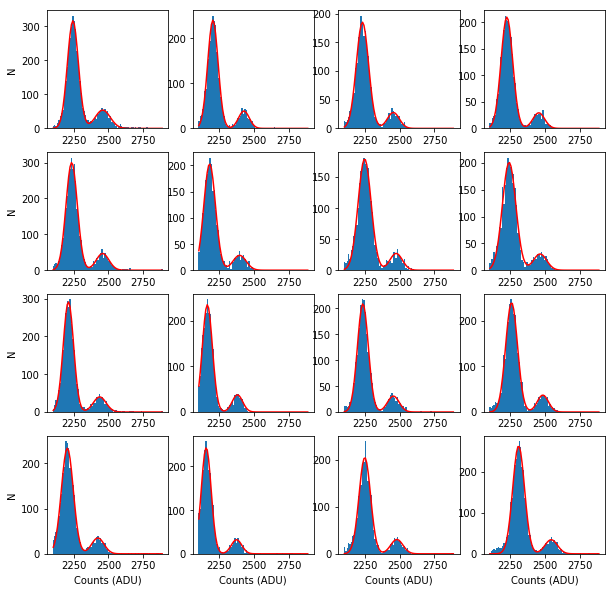

In [11]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i in range(16):
    x = xs[i]
    y = ys[i]
    fit = fits[i]
    indx = i%4
    indy = i//4
    axs[indx][indy].bar(x, y, width=10)
    axs[indx][indy].plot(x, double_gaussian(x, fit[0]), c='r')
    if indx == 3:
        axs[indx][indy].set_xlabel('Counts (ADU)')
    if indy == 0:
        axs[indx][indy].set_ylabel('N')

In [12]:
#afw_display.mtv(work_img) # have a look at an example amp

In [13]:
FE55_electrons = 1594

### Calculate gain and print them

In [14]:
gains = []
for i in range(9*16):
    gains.append(FE55_electrons/fits[i][0][1])
#    print("Gain for amp %s -- %.5f"%(detector[i].getName(), FE55_electrons/fits[i][0][1]))
#    print("Gain for amp %s -- %.5f"%(detector_snames[i], FE55_electrons/fits[i][0][1]))

Text(0,0.5,'gain')

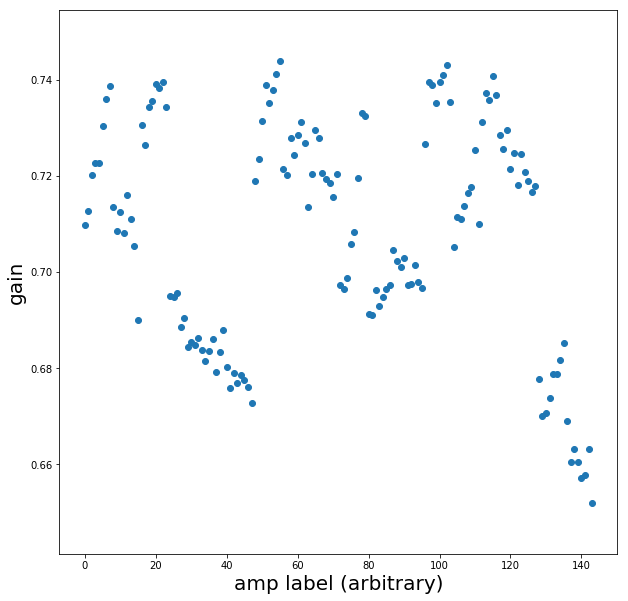

In [15]:
len(gains)

plt.figure(figsize=(10,10))
plt.scatter(numpy.arange(9*16,dtype=int), gains)
plt.xlabel('amp label (arbitrary)', fontsize=20)
plt.ylabel('gain', fontsize=20)